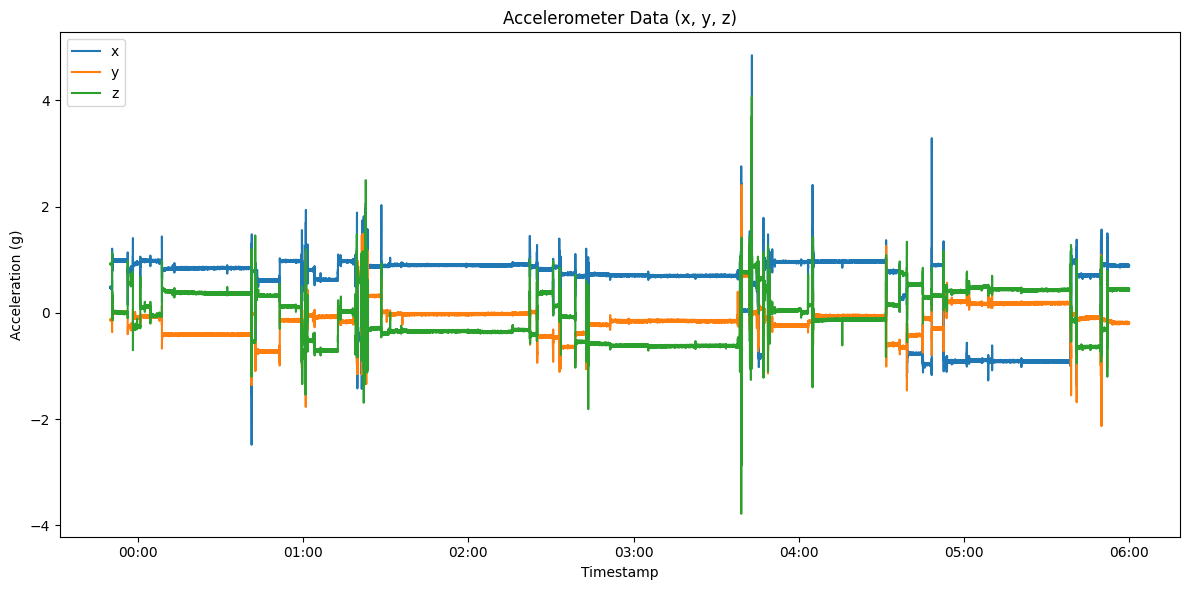

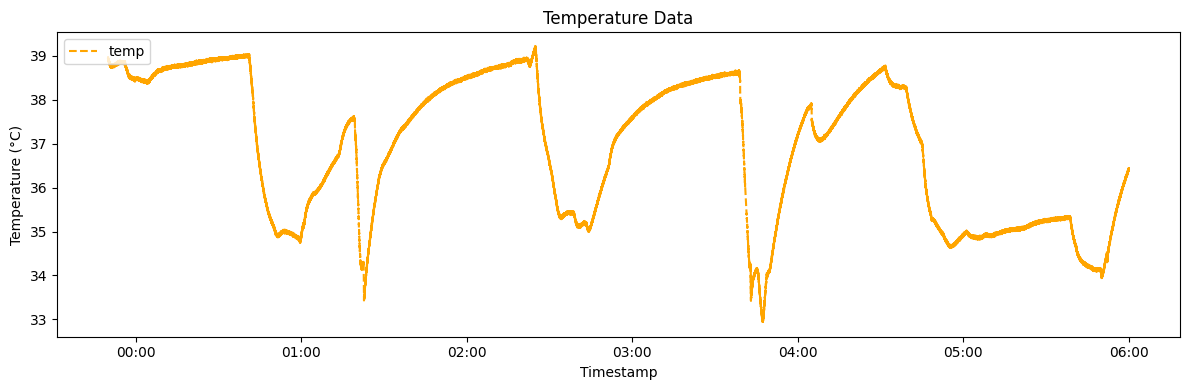

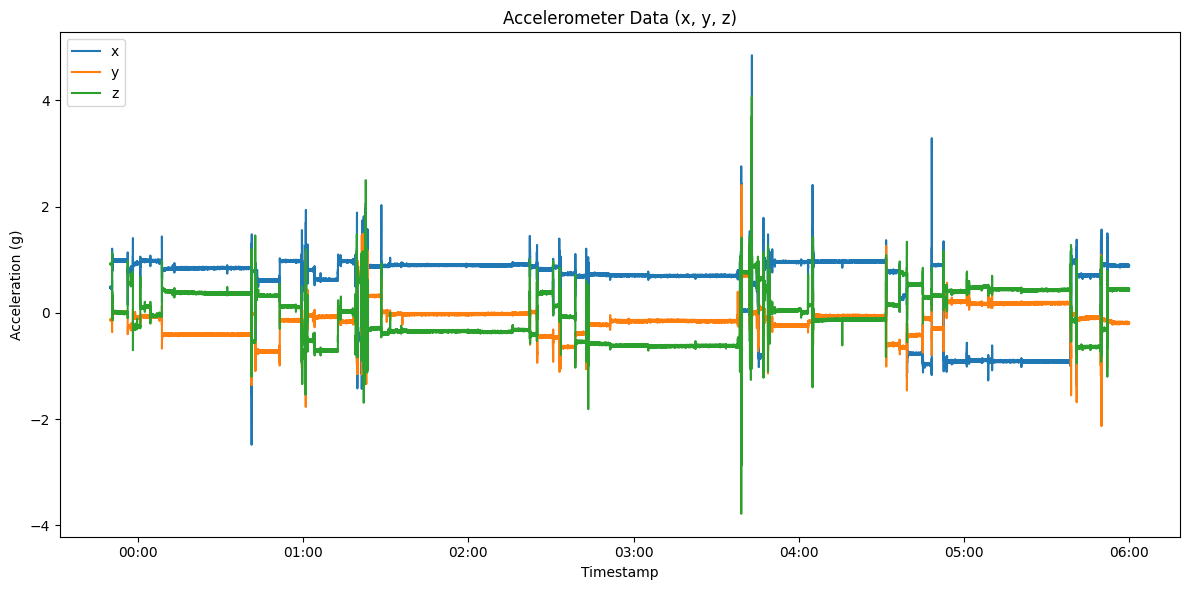

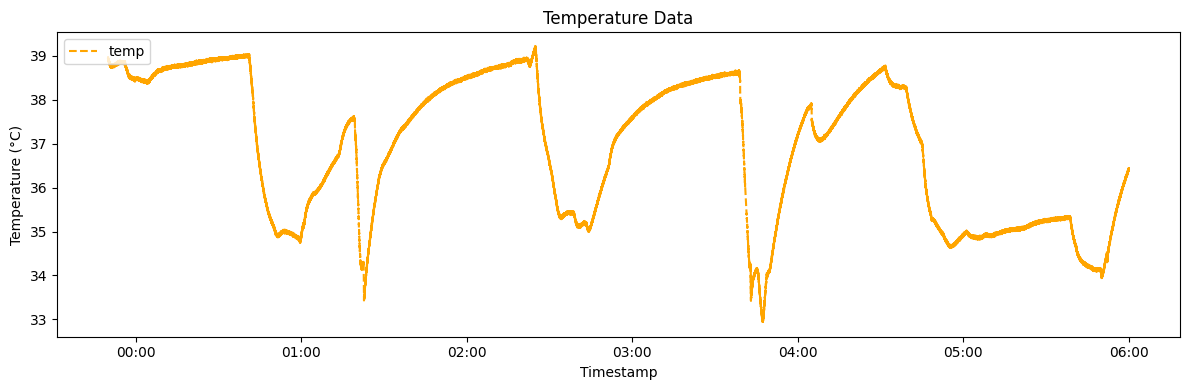

In [12]:
"""
CSV Analysis Tool – Jupyter/Python
---------------------------------
Reads every CSV inside a chosen folder, merges them **in-memory**, and plots all series:
  • `x`, `y`, `z` → first graph (range –1…1)
  • `temperature` → second graph (range  20…50 °C)
Tweak the *Parameters* section and run each cell top-to-bottom in Jupyter.
"""

# %% Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from IPython.display import display

# %% Parameters ——--------------------------
folder = Path('./data/session_20250621_2318')  # ← change me!
file_pattern = '*.csv'
timestamp_col = 'timestamp'
time_start = "23:50"  # format HH:MM
time_end = "06:00"    # format HH:MM

# %% 1) Read & merge all CSVs in-memory
csv_files = sorted(folder.glob(file_pattern))
if not csv_files:
    raise FileNotFoundError(f'No CSV files matching {file_pattern} in {folder}')

frames = []
for f in csv_files:
    df = pd.read_csv(f)
    if df.columns[0] != timestamp_col:
        df.rename(columns={df.columns[0]: timestamp_col}, inplace=True)
    frames.append(df)
raw_data = pd.concat(frames, ignore_index=True)

# %% 2) Timestamp cleanup & ordering
raw_data[timestamp_col] = pd.to_datetime(raw_data[timestamp_col], unit='ms')
raw_data.sort_values(timestamp_col, inplace=True)
raw_data.reset_index(drop=True, inplace=True)

# %% 3) Optional: restrict to time window (e.g. 23:50 to 05:00)
def filter_by_timeframe(df, col, start, end):
    times = df[col].dt.time
    start_h, start_m = map(int, start.split(":"))
    end_h, end_m = map(int, end.split(":"))
    start_t = pd.to_datetime(f"{start_h:02}:{start_m:02}").time()
    end_t = pd.to_datetime(f"{end_h:02}:{end_m:02}").time()
    if start_t <= end_t:
        return df[(times >= start_t) & (times <= end_t)]
    else:
        return df[(times >= start_t) | (times <= end_t)]

if time_start and time_end:
    raw_data = filter_by_timeframe(raw_data, timestamp_col, time_start, time_end)

# %% 4) Plotting — x, y, z on first graph
fig1, ax1 = plt.subplots(figsize=(12, 6))
y_axes_cols = ['x', 'y', 'z']
for col in y_axes_cols:
    if col in raw_data.columns:
        ax1.plot(raw_data[timestamp_col], raw_data[col], label=col)
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Acceleration (g)')
ax1.legend(loc='upper left')
ax1.set_title('Accelerometer Data (x, y, z)')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig1.tight_layout()
display(fig1)
_ = None

# %% 5) Plotting — temperature on second graph
if 'temp' in raw_data.columns:
    fig2, ax2 = plt.subplots(figsize=(12, 4))
    ax2.plot(raw_data[timestamp_col], raw_data['temp'], linestyle='--', label='temp', color='orange')
    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Temperature (°C)')
    ax2.set_title('Temperature Data')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax2.legend(loc='upper left')
    fig2.tight_layout()
    display(fig2)
    _ = None

# %% 6) (Optional) Down-sample if the plot gets crowded
# raw_data_resampled = (raw_data
#                       .set_index(timestamp_col)
#                       .resample('1min').mean()
#                       .dropna(how='all')
#                       .reset_index())
